In [2]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-xde/notebooks'

In [419]:
%load_ext autoreload
%matplotlib inline
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../deepxde/')
os.environ['DDEBACKEND'] = 'pytorch'
import deepxde
deepxde

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'deepxde' from '/ocean/projects/asc170022p/mtragoza/mre-xde/notebooks/../../deepxde/deepxde/__init__.py'>

# 1D inverse Helmholtz problem

We would like to solve an inverse problem for a one-dimensional Helmholtz equation:

$$
\begin{align}
    G \nabla^2 u &= -\rho \omega^2 u \\
    G \frac{\partial^2 u}{\partial x^2} &= -\rho \omega^2 u
\end{align}
$$

Where the goal is to recover $G(x)$ given a training data set of $(x, u(x))$ pairs.

## Define the geometry

We will use DeepXDE to solve the PDE on the interval $x \in [-1, 1]$.


In [420]:
# define the geometry (i.e. domain of x)
geom = deepxde.geometry.Interval(-1, 1)
print(geom)
print(f'dim = {geom.dim}\nbbox = {geom.bbox}\ndiam = {geom.diam}')

dim = 1
bbox = (array([-1]), array([1]))
diam = 2


## Define the PDE residual

Given some candidate solution $(\hat{u}, \hat{q})$, we can rearrange the PDE to obtain a residual:

$$
\begin{align}
    G \nabla^2 u &= -\rho \omega^2 u \\
    0 &= G \nabla^2 u + \rho \omega^2 u \\
    r(x, \hat{u}, \hat{G} ) &= \hat{G} \nabla^2 \hat{u} + \rho \omega^2 \hat{u}
\end{align}
$$

We will train a neural network to minimize this residual, subject to constraints in the form of a set of training data points.

In [421]:
# define the residual of the PDE

rho = 1
omega = 2*np.pi * 2

def pde(x, u_G):
    '''
    Compute PDE residual.
    '''
    u, G = u_G[:,0:1], u_G[:,1:2]
    u_xx = deepxde.grad.hessian(
        ys=u, # output tensor of shape (batch_size, dim_y)
        xs=x, # input tensor of shape (batch_size, dim_x)
        component=None, # index into dim_y
        i=0, j=0 # indices into dim_x
    )
    return G * u_xx + rho * omega**2 * u

## Define a reference solution

Given some true stiffness function $G(x)$ and initial conditions, we can solve for the displacement (i.e. the forward problem) using finite differences:

$$
\begin{align}
    G \frac{\partial^2 u}{\partial x^2} &= -\rho \omega^2 u \\
    G_i \frac{u_{i+1} - 2 u_i + u_{i-1}}{h^2} &= -\rho \omega^2 u_i \\
    G_i \frac{u_{i+1} - 2 u_i + u_{i-1}}{h^2} + \rho \omega^2 u_i &= 0 \\
    \frac{u_{i+1} - 2 u_i + u_{i-1}}{h^2} + \rho \omega^2 \frac{u_i}{G_i} &= 0 \\
    \mathbf{L} \mathbf{u} + \rho \omega^2 \mathbf{G} \mathbf{u} &= 0 \\
    \left( \mathbf{L} + \rho \omega^2 \mathbf{G} \right) \mathbf{u} &= 0 \\
    \mathbf{A} \mathbf{u} &= 0
\end{align}
$$

We will use this approach to define a reference solution to the PDE for training the model.

In [422]:
# functions for defining a 1d discrete Laplacian matrix

def tridiag(a, b, c, n):
    return (
        a * (np.tri(n, k=-1) - np.tri(n, k=-2)) +
        b * np.eye(n) +
        c * (np.tri(n, k=1) - np.tri(n, k=0))
    )

def laplacian_matrix_1d(n_x, dx):
    return tridiag(1, -2, 1, n_x) / dx**2

def print_mat(**kwargs):
    for k, v in kwargs.items():
        v_str = str(v).replace('\n', '\n    ')
        print(f'{k} = \n    {v_str}')

L = laplacian_matrix_1d(n_x=6, dx=1)
print_mat(L=L)

L = 
    [[-2.  1.  0.  0.  0.  0.]
     [ 1. -2.  1.  0.  0.  0.]
     [ 0.  1. -2.  1.  0.  0.]
     [ 0.  0.  1. -2.  1.  0.]
     [ 0.  0.  0.  1. -2.  1.]
     [ 0.  0.  0.  0.  1. -2.]]


In [452]:
# explicit method using causal/upwind difference scheme

def explicit_solver_1d(x, n_x, dx, G, u0, rho, omega):
    u = u0.copy()
    for i in range(2, n_x):
        u[i] = (2 - rho * omega**2 * dx**2 / G[i]) * u[i-1] - u[i-2]
    return u

# implicit method using tridiagonal linear system

def implicit_solver_1d(x, n_x, dx, G, u0, rho, omega):

    # set up linear system
    L = laplacian_matrix_1d(n_x, dx)
    G = np.diag(1 / G[:,0])
    
    A = L + rho * omega**2 * G
    b = np.zeros(n_x)
    
    # determine boundary nodes
    on_boundary = (np.abs(x).max(axis=1) == 1.0)
    
    # set boundary conditions
    A[on_boundary,:] = 0
    A[on_boundary,on_boundary] = 1
    b[on_boundary] = u0[on_boundary,0]
    
    # solve linear system    
    u = np.linalg.solve(A, b)

    return u.reshape(-1, 1)

# define the reference solution

def solution(x, n_x, dx):
    '''
    Compute reference solution.
    '''
    # true stiffness function
    G = np.ones((n_x, 1)) * rho
    G = G + np.exp(-((x+0.5)**2).sum(axis=1, keepdims=True)*100) * rho
    G = G + np.exp(-((x-0.5)**2).sum(axis=1, keepdims=True)*100) * -rho / 2
    
    # solve for displacement
    u = np.sin(omega * x + 1)
    u = implicit_solver_1d(x, n_x, dx, G, u, rho, omega)  

    return u, G

## Define the training data points

We can then use the reference solution to create a set of training data points.

In [453]:
# define the training data set

def gen_train_data(n_x):
    '''
    Generate training data for PDE.
    '''
    x = np.linspace(-1, 1, n_x)
    dx = x[1] - x[0]
    x = x.reshape(-1, 1)
    u, G = solution(x, n_x, dx)
    return x, u, G

n_train = 100 # training points

x, u_true, G_true = gen_train_data(n_train)

print(x.shape, u_true.shape, G_true.shape)

(100, 1) (100, 1) (100, 1)


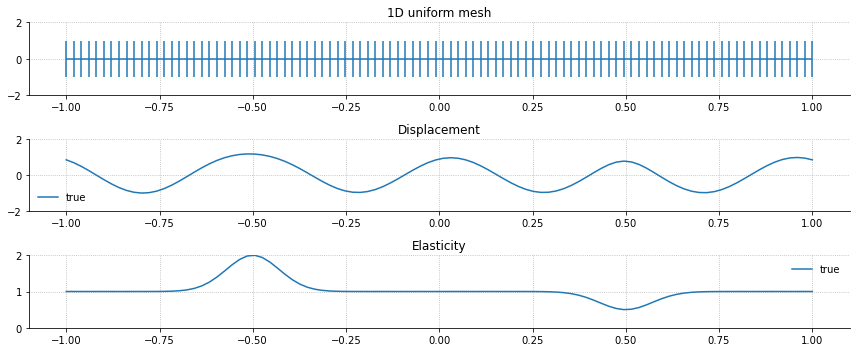

In [454]:
def plot_1d(x, us, Gs):
    
    fig, axes = plt.subplots(3, 1, figsize=(12,5))
    
    # plot mesh
    ax = axes[0]
    ax.set_title('1D uniform mesh')
    ax.hlines(0, -1, 1)
    ax.vlines(x, -1, 1)
    ax.set_ylim(-2, 2)
    
    labels = ['true', 'predicted']
    
    # plot displacement
    ax = axes[1]
    ax.set_title('Displacement')
    for u, label in zip(us, labels):
        ax.plot(x, u, label=label)
        ax.set_ylim(-2, 2)
    ax.legend(frameon=False)
        
    # plot stiffness
    ax = axes[2]
    ax.set_title('Elasticity')
    for G, label in zip(Gs, labels):
        ax.plot(x, G, label=label)
        ax.set_ylim(0, 2*rho)
    ax.legend(frameon=False)
        
    for ax in axes:
        ax.set_axisbelow(True)
        ax.grid(True, linestyle=':')

    sns.despine(fig)
    fig.tight_layout()

plot_1d(x, [u_true], [G_true])

In [455]:
%autoreload

# data is defined by a geometry, PDE residual, and boundary conditions

n_domain = 200 # random samples in domain for PDE loss
n_test  = 1000 # test evaluation points

point_set = deepxde.icbc.PointSetBC(
    points=x, # array of points where target values are known
    values=u_true, # array of values of the exact solution
    component=0
)

data = deepxde.data.PDE(
    geometry=geom, # an instance of Geometry
    pde=pde, # a global PDE or a list of PDEs
    bcs=[point_set], # a boundary condition or list of boundary conditions
    num_domain=n_domain,
    anchors=x, # array of training points in addition to num_domain and num_boundary points
    num_test=n_test # number of points sampled inside the boundary the domain for testing
)

In [456]:
n_layers = 5
n_hidden = 32
activ_fn = 'sin'

net = deepxde.nn.PFNN(
    layer_sizes=[1] + [[n_hidden, n_hidden]] * (n_layers-1) + [2],
    activation=activ_fn,
    kernel_initializer="Glorot uniform"
)
net

PFNN(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Linear(in_features=1, out_features=32, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
    )
    (4): ModuleList(
      (0): Linear(in_features=32, out_features=1, bias=True)
      (1): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [457]:
model = deepxde.Model(data, net)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-5, 1]
)

Compiling model...
'compile' took 0.000368 s



In [460]:
loss_history, train_state = model.train(epochs=10000)

Training model...

Step      Train loss              Test loss               Test metric
10000     [2.36e-05, 6.14e-05]    [2.36e-05, 6.14e-05]    []  
11000     [1.53e-05, 3.01e-05]    [1.52e-05, 3.01e-05]    []  
12000     [1.45e-05, 2.87e-05]    [1.45e-05, 2.87e-05]    []  
13000     [1.26e-04, 5.69e-04]    [1.24e-04, 5.69e-04]    []  
14000     [1.30e-05, 3.49e-05]    [1.29e-05, 3.49e-05]    []  
15000     [5.24e-05, 1.50e-04]    [5.20e-05, 1.50e-04]    []  
16000     [1.63e-05, 4.11e-05]    [1.61e-05, 4.11e-05]    []  
17000     [9.68e-06, 2.09e-05]    [9.65e-06, 2.09e-05]    []  
18000     [8.40e-06, 1.84e-05]    [8.35e-06, 1.84e-05]    []  
19000     [1.03e-05, 1.73e-05]    [1.01e-05, 1.73e-05]    []  
20000     [6.88e-06, 1.16e-05]    [6.77e-06, 1.16e-05]    []  

Best model at step 20000:
  train loss: 1.85e-05
  test loss: 1.84e-05
  test metric: []

'train' took 79.688606 s



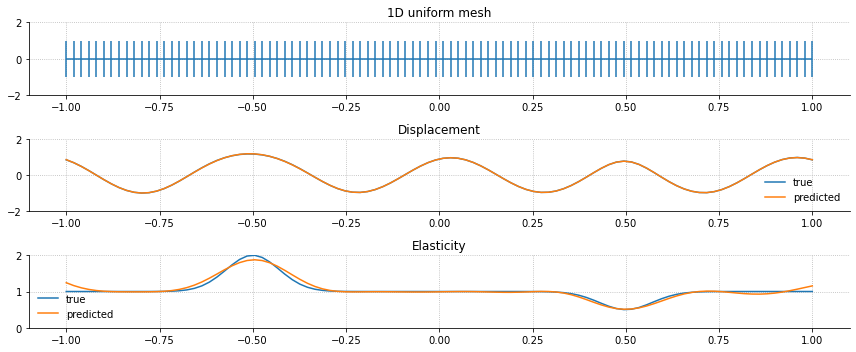

In [461]:
# view results
x = geom.uniform_points(n_train)
u_true, G_true = solution(x, n_train, x[1] - x[0])

u_G_pred = model.predict(x)
u_pred, G_pred = u_G_pred[:, 0:1], u_G_pred[:, 1:2]

plot_1d(x, [u_true, u_pred], [G_true, G_pred])